# Importing the requiered libraries

In [2]:
import urllib, zipfile, os
import matplotlib.pyplot as plt
import numpy as np

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf

# Preparing the dataset

### Download the data

We first need to download the dataset, and organize it in convenient way.

In [25]:
url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"
zip_filename = "CatsVsDogs.zip"
data_path = "PetImages"

# If zip file isn't downloaded yet => download it!
if zip_filename not in os.listdir("."):
    urllib.request.urlretrieve(url, filename = zip_filename)

# If the data inside the zip file isn't extracted yet => extract it!
if data_path not in os.listdir("."):
    with zipfile.ZipFile(zip_filename,"r") as zip_ref:
        zip_ref.extractall()

### Delete corrupted images

In [26]:
# Corrupted images are the ones that do not contain "JFIF" in their bytes representation
classes = os.listdir(data_path) # = ['Cat', 'Dog']

nb_corrupted  = 0
for c in classes:
    class_folder_path = os.path.join(data_path, c)
    image_names = os.listdir(class_folder_path)
    for image_name in image_names:
        image_path = os.path.join(class_folder_path, image_name)
        # Open the image as bytes
        try : 
            file = open(image_path, "rb")
            is_jfif = tf.compat.as_bytes('JFIF') in file.peek(10)
        finally:
            file.close()
        # If the image is corrupted then we delete it!
        if not is_jfif:
            os.remove(image_path)
            nb_corrupted+=1
            
print(f"We have deleted {nb_corrupted} corrupted images")

We have deleted 1590 corrupted images


Now, lets load the data and create our training and validation sets.

Note : Since I will be training on my CPU, instead of using the +20000 images, I will only use 4000!

In [27]:
# We will only use 4000 images
# So let's delete the remaining images
for c in classes:
    class_folder_path = os.path.join(data_path, c)
    images = os.listdir(class_folder_path)
    if len(images) > 2000:
        for idx in range(2000, len(images)):
            image_name = images[idx]
            image_path = os.path.join(class_folder_path, image_name)
            os.remove(image_path)
    print(f"We kept {len(os.listdir(class_folder_path))} images of class {c}")

We kept 2000 images of class Cat
We kept 2000 images of class Dog


### Create the training and validation datasets

In [28]:
# Creating training and validation datasets
batch = 32
image_size = (256,256)

training = tf.keras.utils.image_dataset_from_directory(
    directory = data_path,
    class_names=["Cat", "Dog"], 
    batch_size=batch , 
    image_size=image_size, 
    seed=42, 
    validation_split=0.2, 
    subset="training",
)

validation = tf.keras.utils.image_dataset_from_directory(
    directory = data_path,
    class_names=["Cat", "Dog"], 
    batch_size=batch , 
    image_size=image_size, 
    seed=42, 
    validation_split=0.2, 
    subset="validation",
)

Found 3998 files belonging to 2 classes.
Using 3199 files for training.
Found 3998 files belonging to 2 classes.
Using 799 files for validation.


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


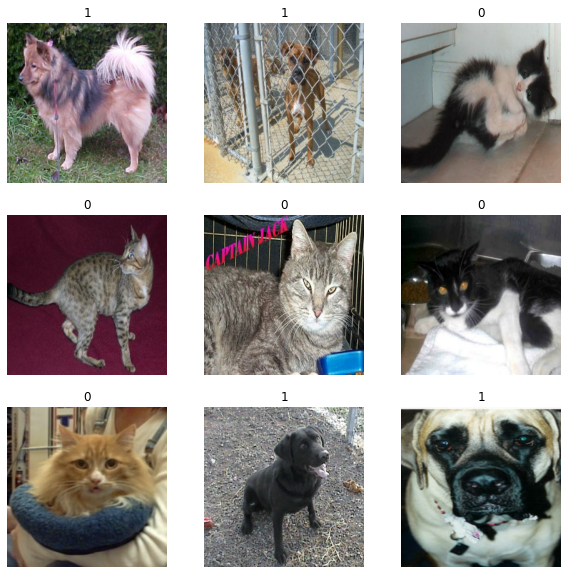

In [7]:
# Visualize the images:
plt.figure(figsize = (10,10))
for images, labels in training.take(1):
    for idx in range(9):
        ax = plt.subplot(3,3,idx + 1)
        ax.imshow(images[idx].numpy().astype("uint8"))
        ax.set_title(int(labels[idx]))
        ax.axis("off")
plt.show()

We can see clearly that our labels are as follow : 
*   Dog  =>  1
*   Cat  =>  0

### Apply data augmentation

Since I am using CPU, I will apply data augmentation outside of the model.
This way it will happen asynchronously which means that it won't block the model during training.

In [8]:
# Apply realistic data augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2)
    ]
)

augmented_training_ds = training.map(lambda x,y : (data_augmentation(x, training = True), [y]))
validation = validation.map(lambda x,y: (x, [y]))

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


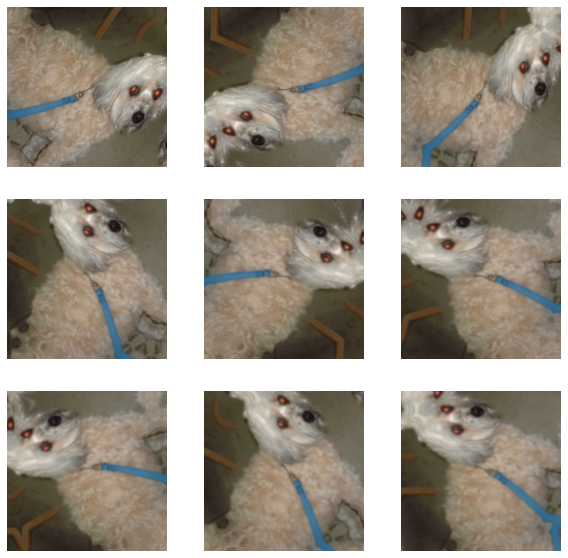

In [9]:
# Visualize the effect of the data augmentation
fig = plt.figure(figsize = (10,10))
for images, labels in training.take(1):
    for idx in range(9):
        images = data_augmentation(images)
        ax = plt.subplot(3,3,idx+1)
        ax.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

Lets use buffered prefetching to get data from disk without having I/O becoming blocking!

This is an interesting optimization.

In [10]:
training = training.prefetch(buffer_size=32)
validation = validation.prefetch(buffer_size=32)

# Create the model

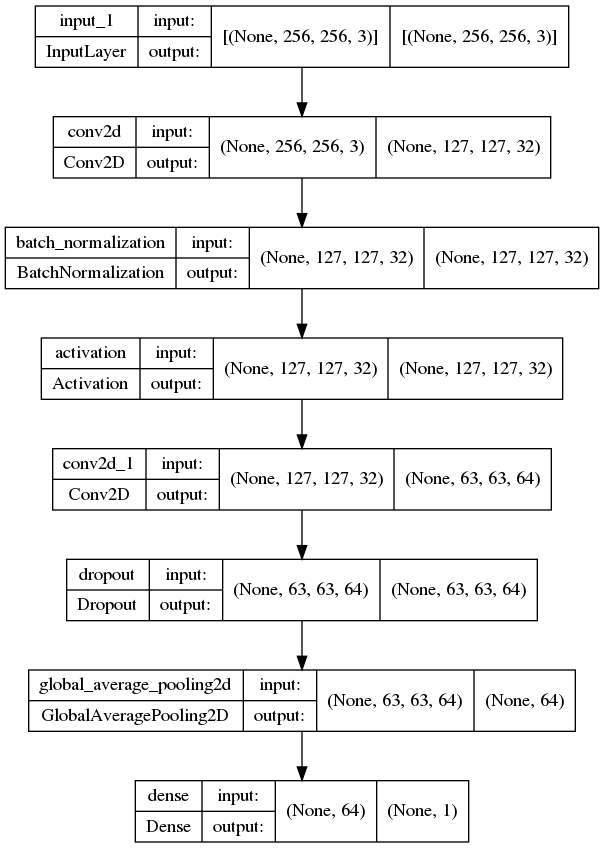

In [11]:
from tensorflow.keras import layers

def createModel(input_shape, num_classes = 2):
    input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, kernel_size = 3, strides = 2)(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(64, kernel_size = 3, strides = 2)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    output = layers.Dense(units, activation = activation)(x)
    model = tf.keras.Model(input, output)
    return model

model = createModel(input_shape= image_size + (3,), num_classes= 2)
tf.keras.utils.plot_model(model, show_shapes= True)


# Compile and train the model

Compile the model.

* We will use the Adam optimizer (High efficiency).
* This is a classification problem so we must use the crossentropy loss function, and since we have two classes (Cats / Dogs) then **binray_crossentropy** is the best choice.

In [12]:
# Compile the model
model.compile(optimizer= tf.keras.optimizers.Adam(1e-3), loss = "binary_crossentropy", metrics=["accuracy"])

When training the model we will implement :
* Tensorboard : An awesome platforme to visualize the training and validation curves and debug training errors.

In [ ]:
# Fit the model
#earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience = 10)
#modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("best_model.h5",save_best_only=True)
#callbacks = [earlyStopping, modelCheckpoint, tensorboard]
nb_epochs ,logdir =  50, "logs"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir)
history = model.fit(augmented_training_ds, epochs=nb_epochs, callbacks=[tensorboard])

If you want to open the tensorboard run the following cell, otherwise you can just skip it.

In [16]:
%load_ext tensorboard
%tensorboard --logdir=logdir

# Evaluate the model's performance

In [33]:
loss, accuracy = tuple(model.evaluate(validation))

 8/25 [========>.....................] - ETA: 1s - loss: 0.6932 - accuracy: 0.4844

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


25/25 [==============================] - 2s 86ms/step - loss: 0.6932 - accuracy: 0.4831


In [34]:
print(f"Loss = {loss} and accuracy = {accuracy}")

Loss = 0.6932191848754883 and accuracy = 0.48310387134552
